In [82]:
import json
from tqdm.notebook import tqdm
import pandas as pd
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext, VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from qdrant_client import QdrantClient
from llama_index.core.retrievers import VectorIndexRetriever
import numpy as np
from rank_bm25 import BM25Okapi
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [83]:
# -----------------------------
# CONFIGURATION
# -----------------------------
TOP_K = 5   # number of results to evaluate at
ALPHA = 0.6 # weight for semantic scores in hybrid fusion

In [84]:
# -----------------------------
# METRIC FUNCTIONS
# -----------------------------

In [85]:
def hit_rate_at_k(results, ground_truth, k):
    """1 if correct doc found in top-k"""
    hits = [1 if gt in res[:k] else 0 for gt, res in zip(ground_truth, results)]
    return np.mean(hits)

def mrr_at_k(results, ground_truth, k):
    """Mean Reciprocal Rank"""
    mrrs = []
    for gt, res in zip(ground_truth, results):
        if gt in res[:k]:
            rank = res.index(gt) + 1
            mrrs.append(1 / rank)
        else:
            mrrs.append(0)
    return np.mean(mrrs)

def recall_at_k(results, ground_truth, k):
    """Recall@K"""
    recall = [1 if gt in res[:k] else 0 for gt, res in zip(ground_truth, results)]
    return np.mean(recall)

def ndcg_at_k(results, ground_truth, k):
    """Simple binary nDCG@K"""
    ndcgs = []
    for gt, res in zip(ground_truth, results):
        if gt in res[:k]:
            rank = res.index(gt)
            dcg = 1 / np.log2(rank + 2)
            idcg = 1.0
            ndcgs.append(dcg / idcg)
        else:
            ndcgs.append(0)
    return np.mean(ndcgs)

In [86]:
##Qdrant(Semantic Search)

In [ ]:
client = QdrantClient(url="http://localhost:6333")
COLLECTION = "saudi_labor_law"
vector_store = QdrantVectorStore(client=client, collection_name=COLLECTION)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
embed_model = HuggingFaceEmbedding(model_name="intfloat/multilingual-e5-base")
index = VectorStoreIndex.from_vector_store(
    vector_store=vector_store,
    storage_context=storage_context,
    embed_model=embed_model
)
retriever = VectorIndexRetriever(index=index, similarity_top_k=TOP_K)

In [88]:
### Hybrid Search ##########

In [89]:
class HybridRetriever:
    def __init__(self, dense_retriever, documents, alpha=0.5):
        self.dense = dense_retriever
        self.docs = documents
        self.alpha = alpha
        self.bm25 = BM25Okapi([d["arabic_content"].split() for d in documents])

    def retrieve(self, query, top_k=5):
        bm25_scores = self.bm25.get_scores(query.split())
        bm25_scores = MinMaxScaler().fit_transform(bm25_scores.reshape(-1, 1)).flatten()

        dense_results = self.dense.retrieve(query)
        dense_scores = np.zeros(len(self.docs))
        for r in dense_results:
            dense_scores[(r.node.metadata['index'] - 1)] = r.score
        dense_scores = MinMaxScaler().fit_transform(dense_scores.reshape(-1, 1)).flatten()

        hybrid_scores = self.alpha * dense_scores + (1 - self.alpha) * bm25_scores
        top_indices = np.argsort(hybrid_scores)[::-1][:top_k]
        return list(top_indices)

In [90]:
def evaluate_retrievers(index, documents, ground_truth_data):
    # Load ground-truth question dataset
    queries = [q["question"] for q in ground_truth_data]
    ground_truth_ids = [q["index"] - 1 for q in ground_truth_data]

    retriever = VectorIndexRetriever(index=index, similarity_top_k=TOP_K)
    hybrid = HybridRetriever(retriever, documents, alpha=ALPHA)

    dense_results, hybrid_results = [], []

    print("\n🚀 Running retrieval evaluation on", len(queries), "queries...")
    for query in tqdm(queries, desc="Evaluating"):
        dense_res = [(r.node.metadata['index'] - 1) for r in retriever.retrieve(query)]
        hybrid_res = hybrid.retrieve(query, top_k=TOP_K)
        dense_results.append(dense_res)
        hybrid_results.append(hybrid_res)

    # Metrics comparison
    metrics = {
        "Hit@K": hit_rate_at_k,
        "MRR@K": mrr_at_k,
        "Recall@K": recall_at_k,
        "nDCG@K": ndcg_at_k,
    }

    results_summary = {}
    print("\n📊 RESULTS (Dense vs Hybrid)")
    for name, fn in metrics.items():
        dense_score = fn(dense_results, ground_truth_ids, TOP_K)
        hybrid_score = fn(hybrid_results, ground_truth_ids, TOP_K)
        results_summary[name] = {"Dense": dense_score, "Hybrid": hybrid_score}
        print(f"{name:10} | Dense: {dense_score:.3f} | Hybrid: {hybrid_score:.3f}")
    return results_summary

In [91]:
def plot_metrics(results_summary):
    metrics = list(results_summary.keys())
    dense_scores = [results_summary[m]["Dense"] for m in metrics]
    hybrid_scores = [results_summary[m]["Hybrid"] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width / 2, dense_scores, width, label="Dense", color="#007ACC")
    plt.bar(x + width / 2, hybrid_scores, width, label="Hybrid", color="#FFB000")

    plt.ylabel("Score")
    plt.title("Retrieval Performance Comparison")
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

In [92]:
documents = json.load(open("data/labor_law/labor_law_parsed.json", encoding="utf-8"))
df_ground_truth = pd.read_csv("data/ground-truth-data.csv")
ground_truth = df_ground_truth.to_dict(orient='records')


🚀 Running retrieval evaluation on 1245 queries...


Evaluating:   0%|          | 0/1245 [00:00<?, ?it/s]


📊 RESULTS (Dense vs Hybrid)
Hit@K      | Dense: 0.664 | Hybrid: 0.665
MRR@K      | Dense: 0.515 | Hybrid: 0.478
Recall@K   | Dense: 0.664 | Hybrid: 0.665
nDCG@K     | Dense: 0.552 | Hybrid: 0.524


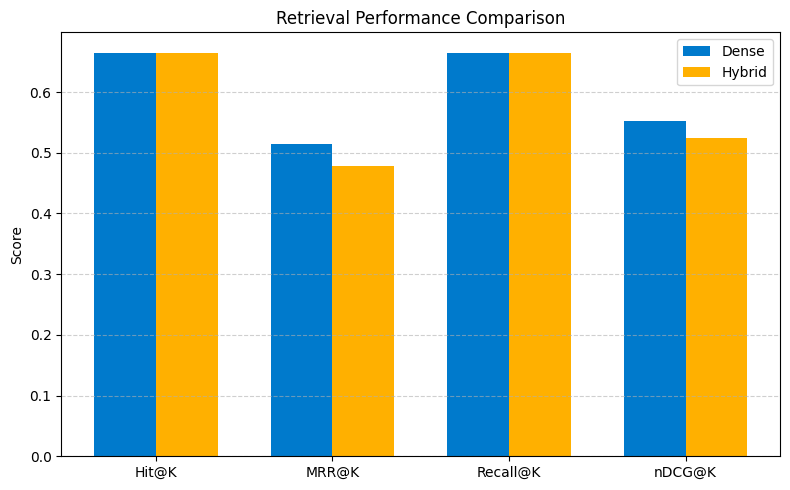

In [93]:
results_summary = evaluate_retrievers(
    index=index,
    documents=documents,
    ground_truth_data=ground_truth
)
plot_metrics(results_summary)